This resnet50 model was trained using 5 classes. This training process is documented in "Custom Dataset Class Testing with Resnet50", since it is when I was working out the better import process.

In [1]:
# Quick check to see how many images there are per class

def count_images(file_path):
    # Finds class folders, makes a list of classes, and counts how many images are in each class
    import os
    from pathlib import Path
    
    image_counter = []
    
    for class_name in os.listdir(file_path):
        # Exclude .DS_Store
        if class_name != '.DS_Store':

            # Make a Path to the class directory
            class_dir = Path(file_path) / class_name

            # Note that this is set to work with .png images and needs modification
            # to work with other types
            image_counter.append(len(os.listdir(class_dir)))
                          
    return image_counter

In [2]:
train_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/train'
train_counts = count_images(train_path)
train_counts

[95, 298, 57, 95, 310]

In [3]:
test_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/test'
test_counts = count_images(test_path)
test_counts

[100, 292, 60, 100, 348]

In [4]:
# Import the image processing functions and class
from image_import import process_image, de_process_image, wormDataset

# Import all needed libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
# These last two are used to save info about how the training progressed
import pickle
import datetime

# Set the full path to the main image directory
train_dir = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/train'
test_dir = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/test'
num_train = 10
num_test = 10

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

traindata = wormDataset(train_dir, means, stds)
testdata = wormDataset(test_dir, means, stds)

# Load from the training and test sets
trainloader = torch.utils.data.DataLoader(traindata, batch_size=num_train, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=num_test, shuffle=True)

# Get the classes
class_names = traindata.classes
print('Detected ' + str(len(class_names)) + ' classes in training data')
print(class_names)

# Print out how many images are in the trainloader and testloader
print("Train batch size = " + str(num_train) + ', test batch size = ' + str(num_test))
print('Trainloder length = ' + str(len(trainloader)) + ', testloader length = ' + str(len(testloader)))

Detected 5 classes in training data
['slightly_out_neg', 'very_out_neg', 'acceptable', 'slightly_out_pos', 'very_out_pos']
Train batch size = 10, test batch size = 10
Trainloder length = 86, testloader length = 90


In [5]:
%%capture 

# Load up the trained model
model_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/compare_num_classes/resnet50_5cat.pth'
model = torch.load(model_path)
model.eval() # Put the model in eval mode

In [6]:
# Evaluate on all images in the test loader
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on ' + str(total) + ' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on 900 test images: 74 %


The model trained on 7 classes has accuracy of 67% after the same number of rounds of training. The model with 3 classes has >90%, but also never classifies anything as acceptable due to sample bias (3 acceptable images in a stack of 40, so many more out of focus than in focus).

This 5 category model was trained when I was still assigning string names to the folders rather than numbering them, which makes a less intuitive confusion matrix. To overcome this I modified the confusion matrix code to re-order the columns and rows for:
0) Very out neg
1) Slightly out neg
2) Acceptable
3) Slightly out pos
4) Very out pos

In [9]:
print(class_names)

['slightly_out_neg', 'very_out_neg', 'acceptable', 'slightly_out_pos', 'very_out_pos']


In [12]:
def label_convert(class_names, label):
    if class_names[label] == 'very_out_neg':
        new_label = 0
    elif class_names[label] == 'slightly_out_neg':
        new_label = 1
    elif class_names[label] == 'acceptable':
        new_label = 2
    elif class_names[label] == 'slightly_out_pos':
        new_label = 3
    else:
        new_label = 4
    return new_label

In [15]:
# Evaluate on all images in the test loader
confusion_matrix = np.zeros((5, 5))

class_names = testdata.classes

with torch.no_grad():
    for data in testloader:
        # This is processing in batches, the number of things in images and labels is the
        # the same as the batch size
        images, labels = data
        outputs = model(images)
        predicted = torch.max(outputs.data, 1)
        num_labels = labels.size(0)
        total += num_labels
        for i in range(num_labels): # Iterate through the labels in the batch
            
            # Increase the cell corresponding to the label / prediction pair by one
            confusion_matrix[label_convert(class_names, labels[i]), label_convert(class_names, predicted.indices[i])] += 1
            
print(confusion_matrix)

[[292.   0.   0.   0.   0.]
 [ 70.   0.  30.   0.   0.]
 [  3.   0.  57.   0.   0.]
 [  0.   0.  71.  28.   1.]
 [  0.   0.   3.  49. 296.]]


In [16]:
# Check that the numbers in the confusion matrix make sense
print('Images in folders:')
print(test_counts)
print('')

print('Labels in Confusion Matrix:')
print(np.sum(confusion_matrix, axis=1))

# The numbers match, and one column has switched position consistent with the convert_label function working

Images in folders:
[100, 292, 60, 100, 348]

Labels in Confusion Matrix:
[292. 100.  60. 100. 348.]


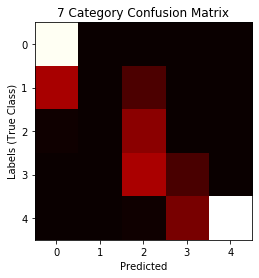

In [17]:
# Make a nicer version of the confusion matrix with axis labels
plt.title('7 Category Confusion Matrix')
plt.ylabel('Labels (True Class)')
plt.xlabel('Predicted')
plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
plt.show()

In [42]:
# Percent accurate
percent_accurate = np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix) * 100
print(percent_accurate)

74.77777777777777


In [43]:
# Row 2 is true acceptable, column 2 is predicted acceptable
# Errors in which an acceptable image is mistaken for out of focus
(np.sum(confusion_matrix[2,:]) - confusion_matrix[2,2]) / np.sum(confusion_matrix) * 100

0.33333333333333337

In [44]:
# Errors in which an out of focus image is mistaken for acceptable
(np.sum(confusion_matrix[:,2]) - confusion_matrix[2,2]) / np.sum(confusion_matrix) * 100

11.555555555555555

In [45]:
# Percent of failure errors
percent_failure = (np.sum(confusion_matrix[2,:]) + np.sum(confusion_matrix[:,2]) - (2 * confusion_matrix[2,2])) / np.sum(confusion_matrix) * 100
print(percent_failure)

11.88888888888889


The 5 category model has a higher accuracy rate overall (74.7%) than the 7 category model (66%). However, the rate of failure errors are comparable at 10.7% in the 7 category model and 11.8% in the 5 category model. However, the rate of mistaking an in focus image for out of focus in the 5 category model is still 1% or lower, so this is good.

In [52]:
# Errors in which the predicted class is a neighbor of the true class
# Subset the confusion matrix and take the diagonals to get the cells on either side of the main diagonal
# (one class off vs. accurate predictions)
neighbors_pos = np.diagonal(confusion_matrix[1:, :3])
np.sum(neighbors_pos) / np.sum(confusion_matrix) * 100

15.666666666666668

In [53]:
neighbors_neg = np.diagonal(confusion_matrix[:3, 1:])
np.sum(neighbors_neg) / np.sum(confusion_matrix) * 100

3.3333333333333335

In [54]:
percent_neighbor = (np.sum(neighbors_pos) + np.sum(neighbors_neg)) / np.sum(confusion_matrix) * 100 
print(percent_neighbor)

19.0


In both the 5 category and 7 category models, there is a tendency for more positive than negative neighbor errors. The number of neighbor errors in the 5 category model appears to be greater, however, I think the main cause is that with 7 categories there are more ways to be wrong that aren't a neighbor error. The 7 category model has lots of these "other" errors

In [49]:
# Errors in which the model gets the direction wrong
# Thinks the plane of focus is above best focus when it is below, and vice-versa
# These are on the upper right to lower left diagonal, get this by flipping the array
np.diagonal(np.fliplr(confusion_matrix))

array([ 0.,  0., 57.,  0.,  0.])

In [50]:
percent_opposite = (np.sum(np.diagonal(np.fliplr(confusion_matrix))) - confusion_matrix[2,2]) / np.sum(confusion_matrix) * 100
print(percent_opposite)

0.0


There are ZERO opposite errors in the 5 category model.

In [55]:
percent_other = 100 - percent_failure - percent_neighbor - percent_opposite - percent_accurate
print(percent_other)
# As of right now I have no idea which one of my measurements is off, need ot figure this out before relying on results

-5.666666666666657


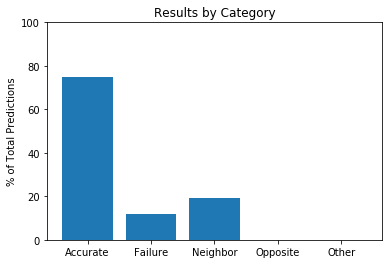

In [58]:
import matplotlib.pyplot as plt
bars = ['Accurate', 'Failure', 'Neighbor', 'Opposite', 'Other']
y_pos = np.arange(len(bars))
plt.bar(y_pos, [percent_accurate, percent_failure, percent_neighbor, percent_opposite, percent_other])
plt.title('Results by Category')
plt.ylabel('% of Total Predictions')
plt.xticks(y_pos, bars)
plt.ylim(0, 100)
plt.show()